In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import similarity_masks as s

from importlib import reload

In [ ]:
class SoftSigMask(nn.Module):
    def __init__(self):
        super().__init__()
        self.a_raw = nn.Parameter(torch.tensor(0.2))  
        self.b_raw = nn.Parameter(torch.tensor(0.5))  
        self.n_raw = nn.Parameter(torch.tensor(0.0)) 

    def forward(self, x):
        # Ensure 0 < a < b < 1
        a = torch.sigmoid(self.a_raw)
        b = a + torch.sigmoid(self.b_raw) * (1 - a)

        # Ensure n > 1
        n = torch.sigmoid(self.n_raw)


        num = (x - a).clamp(min=1e-6).pow(1 / n)
        denom = num + (b - x).clamp(min=1e-6).pow(1 / n)

        soft_mask = num / denom

    
        output = torch.where(x < a, torch.tensor(0.0, device=x.device), soft_mask)
        output = torch.where(x > b, torch.tensor(1.0, device=x.device), output)

        return output, self.a_raw, self.b_raw, self.n_raw

Epoch 0: Loss = 0.3583, a = 0.190, b = 0.010, n = 0.490
Epoch 10: Loss = 0.3341, a = 0.090, b = 0.110, n = 0.390
Epoch 20: Loss = 0.3093, a = -0.011, b = 0.209, n = 0.288
Epoch 30: Loss = 0.2837, a = -0.112, b = 0.308, n = 0.185
Epoch 40: Loss = 0.2576, a = -0.213, b = 0.404, n = 0.080
Epoch 50: Loss = 0.2311, a = -0.315, b = 0.499, n = -0.027
Epoch 60: Loss = 0.2044, a = -0.416, b = 0.590, n = -0.135
Epoch 70: Loss = 0.1778, a = -0.517, b = 0.678, n = -0.245
Epoch 80: Loss = 0.1516, a = -0.618, b = 0.762, n = -0.355
Epoch 90: Loss = 0.1258, a = -0.717, b = 0.841, n = -0.465
Epoch 100: Loss = 0.1008, a = -0.815, b = 0.917, n = -0.575
Epoch 110: Loss = 0.0768, a = -0.911, b = 0.988, n = -0.684
Epoch 120: Loss = 0.0555, a = -1.003, b = 1.053, n = -0.791
Epoch 130: Loss = 0.0387, a = -1.085, b = 1.103, n = -0.894
Epoch 140: Loss = 0.0268, a = -1.155, b = 1.134, n = -0.990
Epoch 150: Loss = 0.0192, a = -1.210, b = 1.144, n = -1.075
Epoch 160: Loss = 0.0149, a = -1.251, b = 1.135, n = -1.14

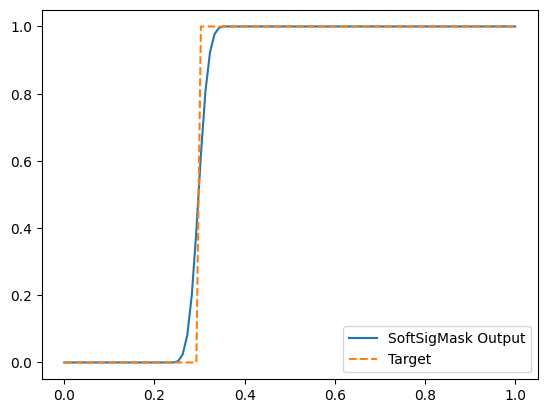

In [2]:
import torch.optim as optim
import matplotlib.pyplot as plt

soft_mask = SoftSigMask()

x = torch.linspace(0, 1, 100).requires_grad_(False) 

optimizer = optim.Adam(soft_mask.parameters(), lr=0.01)

y_target = (x > 0.3).float()

for epoch in range(500):
    optimizer.zero_grad()
    y_pred, a, n, b = soft_mask(x)

    loss = nn.MSELoss()(y_pred, y_target)
    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, a = {a.item():.3f}, b = {b.item():.3f}, n = {n.item():.3f}")

# Plot final function
y_final, _, _, _ = soft_mask(x)
plt.plot(x.detach().numpy(), y_final.detach().numpy(), label="SoftSigMask Output")
plt.plot(x.detach().numpy(), y_target.numpy(), linestyle="dashed", label="Target")
plt.legend()
plt.show()

In [13]:
class SoftMask(nn.Module):
    '''
    Shift similarities to only compare samples to nearest neighbors.
    '''
    def __init__(self):
        super(SoftMask, self).__init__()
        self.k = nn.Parameter(torch.randn(1))
    
    def forward(self, sim):
        # k = self.k.exp() # equivalent to sig(k) / (1 - sig(k)). Allows mask to range over full space.
        sim_mask = (self.k ** 2) * (sim).log()

        return sim_mask, self.k

In [19]:
soft_mask = SoftMask()

x = torch.linspace(1e-6, 1, 100).requires_grad_(False) 

optimizer = optim.Adam(soft_mask.parameters(), lr=1e-2)

true_k_squared = torch.rand(1) ** 2
print(f'true k squared: {true_k_squared.item(): .4f}')
y_target = true_k_squared * x.log() + torch.randn(100) / 10

for epoch in range(5000):
    optimizer.zero_grad()
    y_pred, k = soft_mask(x)

    loss = nn.MSELoss()(y_pred, y_target)
    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f} , k squared = {k.item() ** 2:.4f}")

# Plot final function
y_final, _ = soft_mask(x)
plt.plot(x.detach().numpy(), y_final.detach().numpy(), label="SoftMask Output")
plt.plot(x.detach().numpy(), y_target.numpy(), linestyle="dashed", label="Target")
plt.text(x=0, y=0, s=f'k squared error: {torch.abs(k ** 2 - true_k_squared).item(): .4f}')
plt.legend()
plt.show()

NameError: name 'SoftMask' is not defined

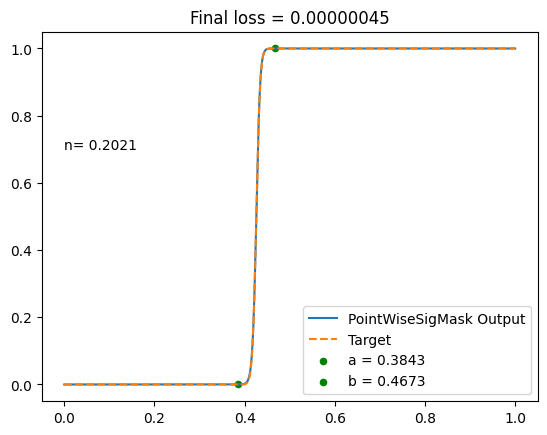

In [143]:
reload(s)
soft_mask = s.PointWiseSigMask(input_dim=1)
soft_mask.min_max(similarity='l2', activation='tanh', d=1)

true_a, true_b, true_n = torch.rand(3)
true_b = true_a + true_b * (1-true_a)

x = torch.linspace(0, 1, 1000).requires_grad_(False).unsqueeze(-1)

num = (x - true_a).clamp(min=1e-12).pow(1 / true_n)  # Avoid zero issues
denom = num + (true_b - x).clamp(min=1e-12).pow(1 / true_n)
y = num / denom
y = torch.where(x < true_a, 0, y)
y = torch.where(x > true_b, 1, y)


optimizer = optim.Adam(soft_mask.parameters(), lr=0.01)


for epoch in range(3000):
    optimizer.zero_grad()
    y_pred = soft_mask(x)
    loss = nn.MSELoss()(y_pred, y)
    loss.backward()

    optimizer.step()
# Plot final function
y_final = soft_mask(x)
plt.plot(x.detach().numpy(), y_final.detach().numpy(), label="PointWiseSigMask Output")
plt.plot(x.detach().numpy(), y.numpy(), linestyle="dashed", label="Target")
plt.title(f"Final loss = {loss.item():.8f}")
plt.scatter(true_a, 0, s=20, color='green', label=f'a ={true_a.item(): .4f}')
plt.scatter(true_b, 1, s=20, color='green', label=f'b ={true_b.item(): .4f}')
plt.text(0, 0.7, f'n={true_n.item(): .4f}')
plt.legend()
plt.show()